In [5]:
import numpy as np
import math
import keras
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import json
import os
import random

Using TensorFlow backend.


In [177]:
NUM_GROUPS = 6

In [6]:
# load annotation files
path = "../data/labels/training_labels_animals.json"
label_root = ""

with open(os.path.join(label_root, path) , 'r') as f:
    train_labels_animals = json.load(f)
    
path = "../data/labels/test_labels.json"
with open(os.path.join(label_root, path), 'r') as f:
    test_labels = json.load(f)
    
path = "../data/labels/training_labels_no_animals.json"
with open(os.path.join(label_root, path), 'r') as f:
    train_labels_no_animals = json.load(f)

#labels = list(labels.items())

In [7]:
# image path
data_root = "G:/Universität/UniBremen/Semester4/Data/maritime_dataset/"#training_data_animals/"

In [167]:
def loadImage(fname):
    "Loads an image as a h*w*3 numpy array"
    img =  img_to_array(load_img(os.path.join(data_root,fname)), dtype="uint8")
    
    #print(f"image before {img.shape}")
    rest_x, rest_y = img.shape[0]%32, img.shape[1]%32
    if rest_x != 0:
        img = np.pad(img, ((0,rest_x),(0, 0),(0,0)), 'constant', constant_values=0)
    if rest_y != 0:        
        img = np.pad(img, ((0,0),(0, rest_y),(0,0)), 'constant', constant_values=0)
        
    return img

# Load the first image an d get the shape of that: All images have the same size
def shapeOfFilename(fname):
    "Returns the imageshape of fname (filename)."
    imageShape = loadImage(fname)
    return imageShape.shape


imageShape = shapeOfFilename("training_data_animals/0.jpg")
print(f"Image format {imageShape}.")

Image format (2848, 4288, 3).


In [159]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 27

def showImageWithAnnotation(entry):
    "Shows image with filename entry[0] and annotated crosses entry[1] (list of dict with 'x', 'y')"
    image = loadImage(entry['filename'])
    plt.imshow(image)
    x_front = [animal["front"][0] for animal in entry['animals']]
    y_front = [animal["front"][1] for animal in entry['animals']]
    x_back = [animal["back"][0] for animal in entry['animals']]
    y_back = [animal["back"][1] for animal in entry['animals']]
    plt.scatter (x_front, y_front, marker="o", c="w")
    plt.scatter (x_back, y_back, marker="x", c="b")
    plt.show()

image before (2848, 4272, 3)


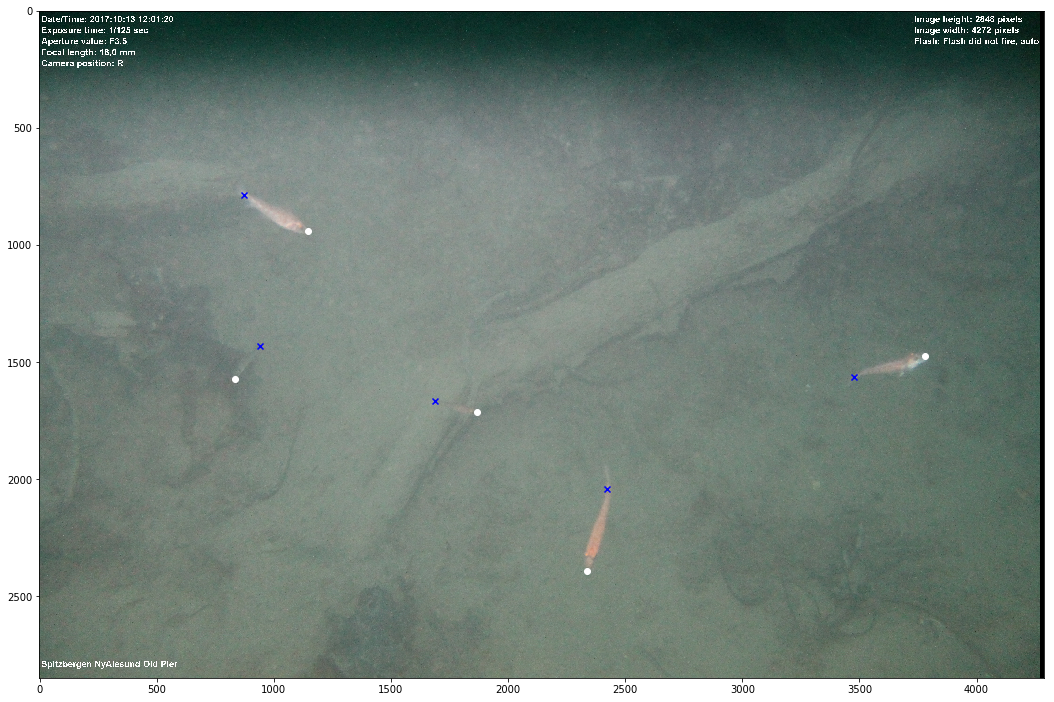

In [166]:
# Test for a random image from the dataset
#showImageWithAnnotation(random.choice(train_labels_animals))
showImageWithAnnotation(train_labels_animals[0])

In [13]:
def addToHeatmap (hm, block, x, y):
    """Adds block to hm[y:y+block.shape[0],x:x+block.shape[1]] and 
     works even if part of block extends outside hm. hm and block
     have both 3 dimensions (w*h*c)."""
  # We have a rectangle hm[hylo:hyhi,hxlo:hxhi] 
  # and a rectangle block[bylo:byhi,bxlo:bxhi] which should be added to the
  # hm-rectangle. Some of the h-indices may be out of bounds in which case
  # both the h-index and the corresponding b-index must be adapted.
    bsy, bsx,_ = block.shape
    hsy, hsx,_ = hm.shape
    # Initially start with considering the full b-block
    hxlo = x
    hylo = y
    hxhi = x+bsx
    hyhi = y+bsy
    bxlo = 0
    bylo = 0
    bxhi = bsx
    byhi = bsy
    if 0<=hxlo and hxhi<=hsx and 0<=hylo and hyhi<=hsy: # fully inside hm
        hm[hylo:hyhi,hxlo:hxhi] += block
    else: 
        if hxlo<0: hxlo, bxlo = 0, bxlo-hxlo # clip left side
        if hxhi>hsx: hxhi, bxhi = hsx, bxhi+hsx-hxhi # clip right side
        if hylo<0: hylo, bylo = 0, bylo-hylo # clip top side
        if hyhi>hsy: hyhi, byhi = hsy, byhi+hsy-hyhi # clip bottom side
        if bxlo>=bxhi or bylo>=byhi: return # fully outside hm
        #print(f"hm[{hylo}:{hyhi},{hxlo}:{hxhi}] += block[{bylo}:{byhi},{bxlo}:{bxhi}]")
        hm[hylo:hyhi,hxlo:hxhi] += block[bylo:byhi,bxlo:bxhi]

In [43]:
print(f"image shape {imageShape}\nlow res {imageShape[0]/32, imageShape[1]/32,}")
print(imageShape[1]/32)

image shape (2848, 4272, 3)
low res (89.0, 133.5)
133.5


In [49]:
4272//133

32

In [51]:
imageShape[1]%32/32

0.5

In [174]:
def interpolate (x):
    """Returns an interpolation (xInt, alpha) that distributes a 1 between
     xInt and xInt+1, where xInt<=x<xInt+1 such that alpha goes into
     xInt and (1-alpha) into xInt+1. It does this in a way that is linear
     in x and where for an integer x, xInt=x."""
    xInt = math.floor(x)
    return (xInt, 1-(x-xInt))
  
def annotationToLowResHeatmap (annotation, group = 1, bodyPart = 'front'):
    """Converts a list of points (each a dict with 'x' and 'y' component) into 
     a heatmap with 1/32 of image resolution. A 1 is bilinearly distributed
     among the 4 heatmap pixels close to the annotated strawberry. This means,
     if the annotated strawberry is in the center of a heatmap pixel, this
     pixel gets increased by 1, if it is on the border between two pixel
     both get increased by 0.5 ,if it is on the corner between four pixel
     each gets increased by 0.25."""
    """group: 0 - nothing, 1 - fish, 2 - crustacea, 3- chaetognatha, 4 - unidentified_object, 5 - jellyfish
    bodyPart: 'front' or 'back'"""
    
    assert bodyPart == "front" or bodyPart == "back"
    assert group in range(NUM_GROUPS)
    
    hm_y, hm_x = imageShape[0]//32, imageShape[1]//32
    
    group_array = np.zeros(NUM_GROUPS)
    group_array[group] = 1
        
    hm = np.zeros ((hm_y, hm_x, 1), dtype=np.float32)
    
    for animal in annotation:
        if np.array_equal(animal['group'], group_array):
            x, y = animal[bodyPart][0], animal[bodyPart][1]
            #print(x)
            hmx, alphaX = interpolate ((x-16)/32) # increase hmx by alpha, and hmx+1 by 1-alpha
            hmy, alphaY = interpolate ((y-16)/32) # increase hmy by alpha, and hmy+1 by 1-alpha

            step_x = 1
            step_y = 1

            #if hmx + 1 > hm.shape[1] and rest_x != 0: step_x = rest_x
            #if hmy + 1 > hm.shape[0] and rest_y != 0: step_y = rest_y

            if 0 <= hmx < hm.shape[1] and 0 <= hmy < hm.shape[0]: 
                hm[hmy, hmx, 0] += alphaX*alphaY

            if 0 <= hmx+ step_x < hm.shape[1] and 0 <= hmy < hm.shape[0]: 
                hm[hmy, hmx+step_x, 0] += (1-alphaX)*alphaY

            if 0 <= hmx < hm.shape[1] and 0 <= hmy+step_y < hm.shape[0]: 
                hm[hmy+step_y, hmx, 0] += alphaX*(1-alphaY)

            if 0 <= hmx+step_x < hm.shape[1] and 0 <= hmy+step_y < hm.shape[0]: 
                hm[hmy+step_y, hmx+step_x, 0] += (1-alphaX)*(1-alphaY)


    return hm

def gaussian (sigma, dim):
    """Returns a dim*dim*1 array with a not normalized 
     Gaussian centered at dim//2, dim//2
     with peak value 1 and the given sigma."""
    x,y,z = np.mgrid[0:dim,0:dim,0:1]
    cx=dim//2
    cy=dim//2
    return np.exp(-((x-cx)**2+(y-cy)**2)/(2*sigma**2))

myGaussian = gaussian (8,50)
print (np.sum(myGaussian))
print (31060*400/(1590*1280*320)*0.2)

def annotationToHighResHeatmap (annotation, group = 1, bodyPart = "front"):
    """Converts a list of points (each a dict with 'x' and 'y' component) into 
     a heatmap with original image resolution using myGaussian. For every 
     strawberry, the Gaussian myGaussian (peak 1) centered at the 
     annotated strawberry point is added."""
    """group: 0 - nothing, 1 - fish, 2 - crustacea, 3- chaetognatha, 4 - unidentified_object, 5 - jellyfish
    bodyPart: 'front' or 'back'"""
    
    assert bodyPart == "front" or bodyPart == "back"
    assert group in range(NUM_GROUPS)
    
    hm = np.zeros ((imageShape[0], imageShape[1], 1), dtype=np.float32)
    group_array = np.zeros(NUM_GROUPS)
    group_array[group] = 1

    for animal in annotation:
        if np.array_equal(animal['group'], group_array):
            x = animal[bodyPart][0]
            y = animal[bodyPart][1]

            if 0<=x <hm.shape[1] and 0<=y<hm.shape[0]: 
                addToHeatmap (hm, myGaussian, x-myGaussian.shape[1]//2, y-myGaussian.shape[0]//2)

    return hm

400.6754273666357
0.0038153498427672956


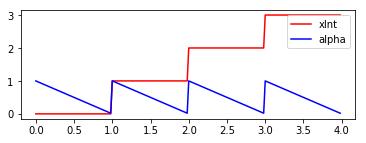

In [15]:
# Use this to test whether interpolate works
def showInterpolate():
    "Helper function to check that interpolate works"
    x = np.arange(0,4,0.02)
    xInt = [interpolate(myX)[0] for myX in x]
    if not type(xInt[0]) is int:
        raise TypeError(f"First result of interpolate must be int but is {xInt[0]}")
    alpha = [interpolate(myX)[1] for myX in x]
    plt.figure(figsize=(6,2))
    plt.plot (x, xInt, 'r', label='xInt')
    plt.plot (x, alpha, 'b', label='alpha')
    plt.legend()
    plt.show ()
  
showInterpolate()

In [207]:
def showImageWithHeatmap (image, hm=None, gt=None, filename=None, group=1, bodyPart="front"):
    """Shows image, the annotation by a heatmap hm [0..1] and the groundTruth gt. 
     The hm.shape must be an integer fraction of the image shape. gt must 
     have be a list of dicts with 'x' and 'y' entries as in the dataset. 
     Both hm and gt can be None in which case they are skipped. 
     If filename is given, the plot is saved."""
    if hm is not None:
        
        assert bodyPart == "front" or bodyPart == "back"
        assert group in range(NUM_GROUPS)
        
        group_array = np.zeros(NUM_GROUPS)
        group_array[group] = 1
        
#         factor_x = image.shape[0]//hm.shape[0]
#         factor_y = image.shape[1]/hm.shape[1]
        
#         print(f"factor_x {factor_x}\nfactor_y {factor_y}\nhm.shape {hm.shape}\image shape {image.shape}")
#         print(hm.shape[0]*factor_x==image.shape[0])
#         print(hm.shape[1]*factor_y==image.shape[1])
        
#         assert hm.shape[0]*factor_x==image.shape[0] and hm.shape[1]*factor_y==image.shape[1]
        
        factor = image.shape[0]//hm.shape[0]
        #print(f"factor {factor}\nhm.shape {hm.shape}\image shape {image.shape}")
        assert hm.shape[0]*factor==image.shape[0] and hm.shape[1]*factor==image.shape[1]
        assert len(hm.shape)==3
        hmResized = np.repeat (hm, factor, axis=0) # y
        hmResized = np.repeat (hmResized, factor, axis=1) #x
#         hmResized = np.repeat (hm, factor_y, axis=0) # y
#         hmResized = np.repeat (hmResized, factor_x, axis=1) #x
        hmResized = np.repeat (hmResized, 3, axis=2) # factor for RGB
        hmResized = np.clip (hmResized*2, 0, 1)
        
        #print(f"heatmap resized {hmResized.shape}")
        if image.dtype =="uint8":
            image = image//2 + (128*hmResized).astype(np.uint8)
            #image = image/2 + (128*hmResized).astype(np.uint8)
        else:
            image = ((image+1)*64 + 128*hmResized).astype(np.uint8)
    plt.imshow(image)
    
    if gt is not None:
        x = [animal[bodyPart][0] for animal in gt if np.array_equal(animal['group'], group_array) ]
        y = [animal[bodyPart][1] for animal in gt if np.array_equal(animal['group'], group_array)]
        
        marker = "o" if bodyPart == "front" else "x"
        plt.scatter (x, y, marker=marker, c="b")
        
    if filename is not None:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

factor 32
hm.shape (89, 134, 1)\image shape (2848, 4288, 3)
heatmap resized (2848, 4288, 3)


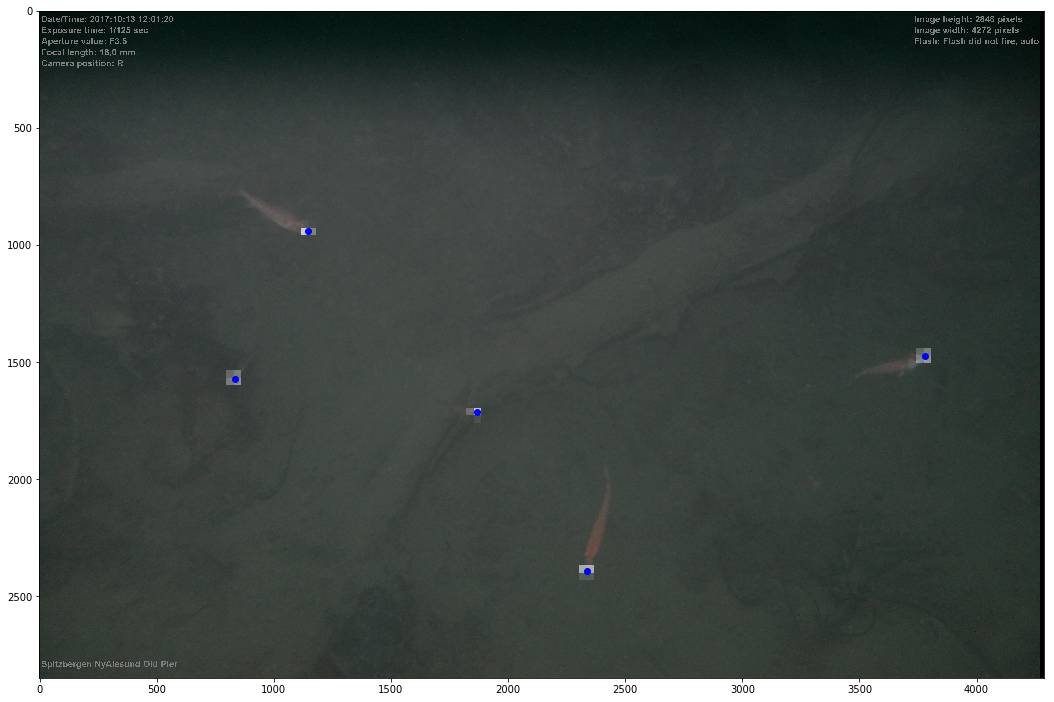

factor 1
hm.shape (2848, 4288, 1)\image shape (2848, 4288, 3)
heatmap resized (2848, 4288, 3)


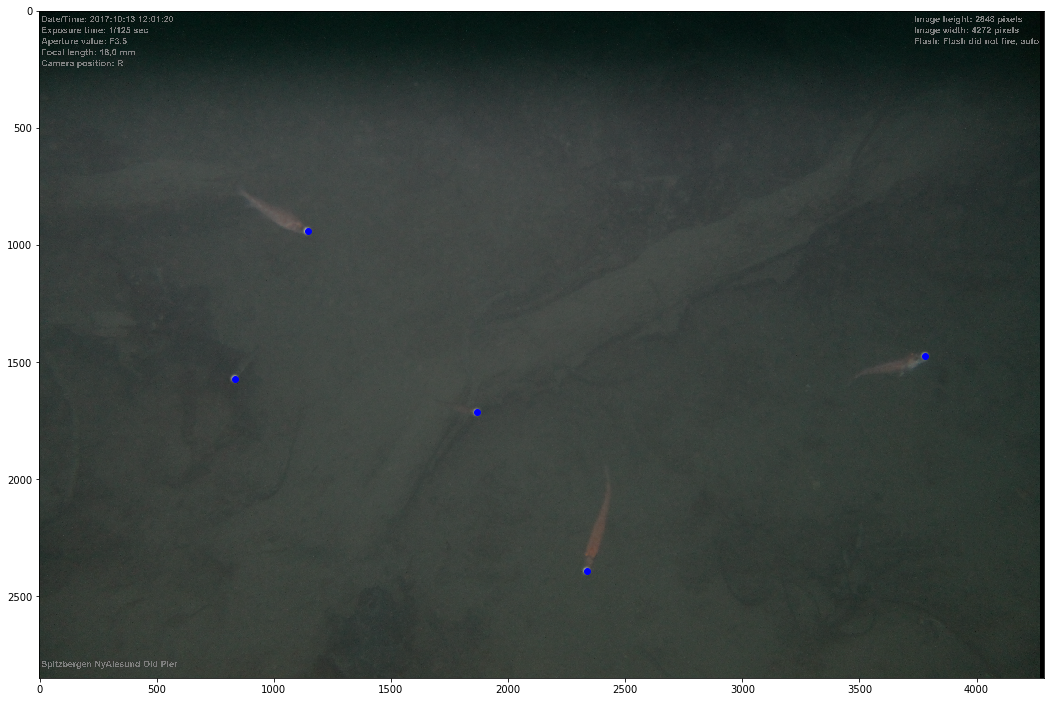

In [188]:
# Show a random entry of the dataset with the annotation converted to a 
# low-res / high-res heatmap
# Use this function to check that annotationToLowResHeatmap 
# and annotationToHighResHeatmap work.
n = random.randint(0,len(train_labels_animals))
n = 0
bodyPart = "front"
group = 1
showImageWithHeatmap (loadImage(train_labels_animals[n]['filename']), annotationToLowResHeatmap(train_labels_animals[n]['animals'], bodyPart=bodyPart, group=group), train_labels_animals[n]['animals'], "annotation.png", bodyPart=bodyPart, group=group)
showImageWithHeatmap (loadImage(train_labels_animals[n]['filename']), annotationToHighResHeatmap(train_labels_animals[n]['animals'], bodyPart=bodyPart, group=group), train_labels_animals[n]['animals'], "annotation.png", bodyPart=bodyPart, group=group)

In [211]:
# Tools to load the training / test set on the fly, so the whole dataset
# doesn't need to be kept in memory.
def dummyPrepareEntry (entry):
    """Dummy function to prepare an entry of the dataset. It takes one entry
     and converts it to a input, ground-truth output pair that is given
     to keras. At the moment the image is loaded and the output is just empty."""
    return (loadImage(entry['filename']), [])

class DataGenerator(keras.utils.Sequence):
    """Provides a dataset of the erdbeer to keras in a load on demand fashion
    The dataset must have the format dict filename-->list[dict{"x", "y"}].
    To obtain the actual entry, the filename is loaded and converted to
    an image and the labels passed to a given function to convert it into
    a tensor.
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly"""
    
    def __init__(self, dataset, prepareEntry=dummyPrepareEntry, batch_size=1, shuffle=True):
        'Initialization'
        self.dataset = dataset
        self.prepareEntry = prepareEntry
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))
      
    def __getitem__(self, index):
        'Generate one batch of data'
        batch = self.dataset[index*self.batch_size:(index+1)*self.batch_size]
        batch = [self.prepareEntry(e) for e in batch]
        X = np.array([e[0] for e in batch])
        y = np.array([e[1] for e in batch])
        return X, y
        
    def get_ground_truth (self, index):
        'Generate ground_truth for the batch in the original format (not heatmap).'
        batch = self.dataset[index*self.batch_size:(index+1)*self.batch_size]
        return [e[1] for e in batch]          

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        random.shuffle(self.dataset)

In [205]:
def prepareEntryLowResHeatmap (entry):
    """Get's an entry of the dataset (filename, annotation), load filename and
    converts annotation into a low-res heatmap. Returning both as x, y pair.
    to be passed to keras."""
    
    filename = entry['filename']
    annotation = entry['animals']
    
    return (loadImage(filename)/np.array(128,dtype=np.float32)-np.array(1,dtype=np.float32), annotationToLowResHeatmap(annotation))

def prepareEntryHighResHeatmap (entry):
    """Get's an entry of the dataset (filename, annotation), load filename and
    converts annotation into a low-res heatmap. Returning both as x, y pair.
    to be passed to keras."""
    
    filename = entry['filename']
    annotation = entry['animals']
    
    return (loadImage(filename)/np.array(128,dtype=np.float32)-np.array(1,dtype=np.float32), annotationToHighResHeatmap(annotation))

X has shape(1, 2848, 4288, 3), type float32 and range [-1.0..0.9921875]
y has shape(1, 89, 134, 1), type float32 and range [0.0..0.791015625]


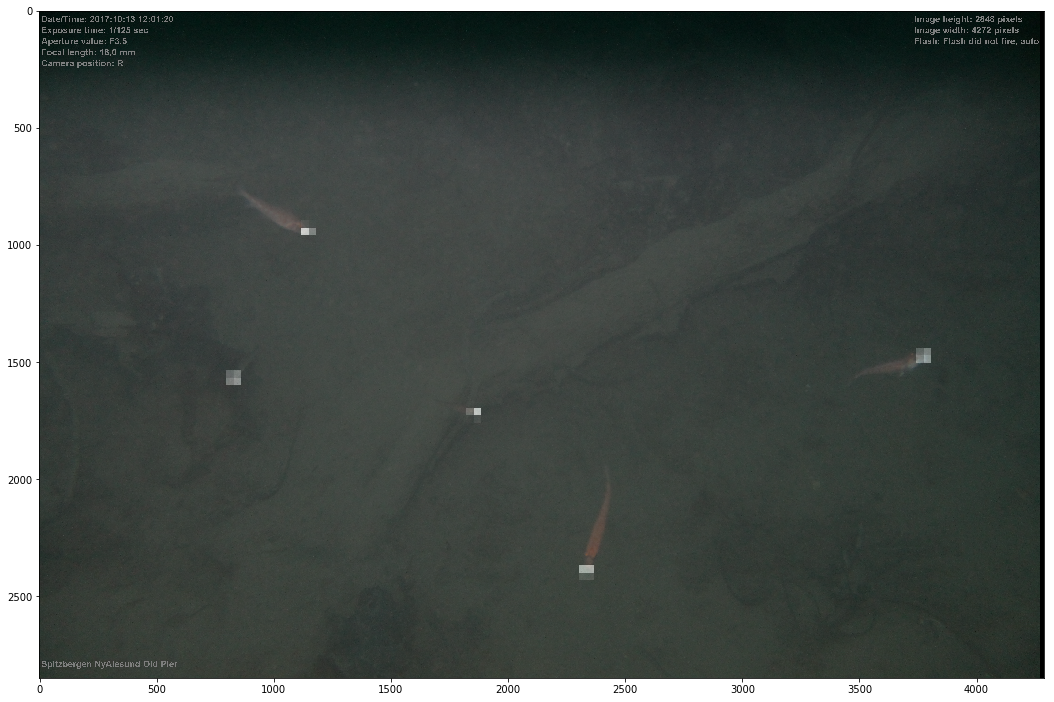

X has shape(1, 2848, 4288, 3), type float32 and range [-1.0..0.9921875]
y has shape(1, 2848, 4288, 1), type float32 and range [0.0..1.0]


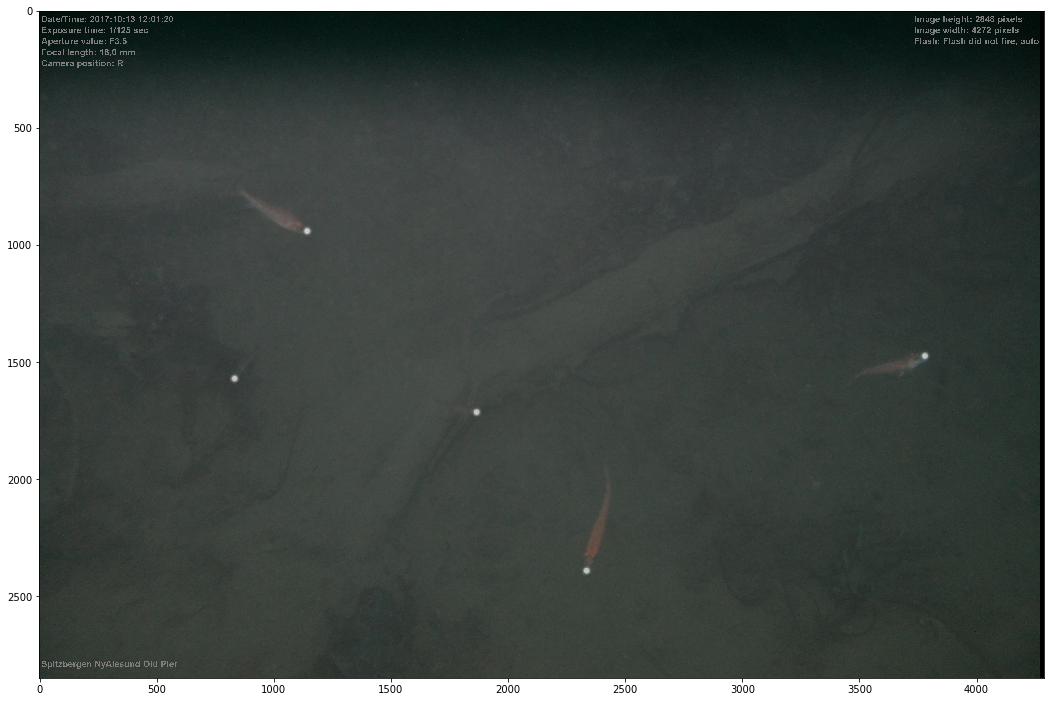

In [212]:
# Use this to test that the data generator works and in particular that the format,
# datatypes and value ranges are correct
def showFirstEntryOfGenerator (dataGen):
    """Fetches the first batch, prints dataformat statistics and 
    shows the first entry both as image X and annotation y."""    
    X, y = dataGen[0]
    print(f"X has shape{X.shape}, type {X.dtype} and range [{np.min(X)}..{np.max(X)}]")
    print(f"y has shape{y.shape}, type {y.dtype} and range [{np.min(y)}..{np.max(y)}]")
    showImageWithHeatmap (X[0], y[0]) 

trainGenL = DataGenerator (train_labels_animals, prepareEntry=prepareEntryLowResHeatmap)
trainNoGenL = DataGenerator (train_labels_no_animals, prepareEntry=prepareEntryLowResHeatmap)
testGenL = DataGenerator (test_labels, prepareEntry=prepareEntryLowResHeatmap)
showFirstEntryOfGenerator (trainGenL)

trainGenH = DataGenerator (train_labels_animals, prepareEntry=prepareEntryHighResHeatmap)
trainNoGenH = DataGenerator (train_labels_no_animals, prepareEntry=prepareEntryHighResHeatmap)
testGenH = DataGenerator (test_labels, prepareEntry=prepareEntryHighResHeatmap)
showFirstEntryOfGenerator (trainGenH)

In [209]:
# Now construct the low-res net and store it into the variable model
# Loading of MobileNet.V2 will give a warning "`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default."
# That's correct.
# Proceed as described in abv-uebung-6.pdf and discuss the architecture.
# Inspect the architecture with model.summary() to make sure, that the number of trainable weights
# is compatible to the amount of data we have.
#
# For reference you can access the MobileNet.V2 source code at
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py

def ourBlock (x, basename, channels=8):
    """Our own block of computation layers used several times in the network. It is similar to
    the block used in MobileNet.V2 but simplified. x is the layer to attach the block to,
    basename the name of this block, which will be extended by layer names. channel is the
    number of channels in the output (internally a multiple of that). The final layer is returned."""
    # First reduce to the defined no of channels to avoid having too many weights
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_bottleneck_conv")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_bottleneck_BN')(x)
    x = layers.ReLU(6., name=basename+'_bottleneck_relu')(x)

    x = layers.Conv2D (4*channels, 1, padding='same', name = basename+"_conv")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_BN')(x)
    x = layers.ReLU(6., name=basename+'_relu')(x)

    x = layers.DepthwiseConv2D(kernel_size=3, activation=None, use_bias=False, padding='same', name=basename+'-DW')(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_DW_BN')(x)
    x = layers.ReLU(6., name=basename+'_DW_relu')(x)
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_project")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_project_BN')(x)
    
    return x

alpha = 1.0
input = keras.layers.Input(shape=imageShape)
backbone = keras.applications.mobilenet_v2.MobileNetV2(alpha=alpha, input_tensor=input, include_top=False, weights='imagenet', pooling=None)
for l in backbone.layers:
    l.trainable = False
# We attach to the layer with 320 channels because with a 1280 channel input this conv would have too many weights
x = backbone.get_layer("block_16_project_BN").output

# Computational block á la MobileNet.V2
x = ourBlock (x, "block_17")
   
# Final output layer with sigmoid, because heatmap is within 0..1
x = layers.Conv2D (1, 1, padding='same', activation='sigmoid', name = "block_18_conv_output")(x)

modelL = keras.Model(inputs=input, outputs=x)
modelL.compile(loss='mse', optimizer='adam', metrics=['mae'])
modelL.summary()

C:\Users\yjenn\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2848, 4288, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 2849, 4289, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 1424, 2144, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 1424, 2144, 3 128         Conv1[0][0]                      
_____________________________

In [213]:
# Train the low-res-net
#model.load_weights ("strawberry-L.h5"), #load a previous checkpoint
for ctr in range(10):
    modelL.fit_generator(generator=trainGenL, epochs=10, validation_data=testGenL)
    modelL.save_weights("fish-L.h5") # saves weights (e.g. a checkpoint) locally
  #files.download('fish-L.h5') # download weights from e.g. google-colab to local machine

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[1,96,1424,2144] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node block_1_expand/convolution (defined at C:\Users\yjenn\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_12346]

Function call stack:
keras_scratch_graph


In [ ]:
# Use this to visualize results
# It shows the input image (background), the predicted heatmap (white "fog" in foreground)
# and the ground-truth (blue crosses)
testIdx = random.randint(0,len(testGenL))
testBatch = testGenL[testIdx]
gtBatch = testGenL.get_ground_truth (testIdx)
yHats = modelL.predict (testBatch[0])
for i in range(0,len(yHats)):
    showImageWithHeatmap (testBatch[0][i], yHats[i], gtBatch[i], filename=f"result-L-{i}.png") 